# Assumptions

## Based on Dave McClure style return tables
* Both Kiran and Standard funds do £200k initial checks to preserve “apples to apples” fairness.
* Follow-on logic for the Standard fund :
    1. Filter for A and B rounds (only certain brackets of deals can raise).
    2. Dry powder concept: Standard invests fewer seed checks or invests less in total seed to retain leftover for A/B.
       * Concretely, we’ll do 40 deals × £200k = £8M at seed, leaving £12M leftover for follow-ons.
* Kiran’s big exits (Large/Unicorn) delayed to year≥7, so it doesn’t get massive IRRs from quick flips.
* Bracket probabilities and multiples tuned in a Dave McClure–like manner.
* Fee schedule:
    * 2% years 0..5
    * 1.5% years 6..9
    * 0% year 10

### Imports: 
NumPy, Matplotlib, Seaborn, Pandas, and the utility libraries (aquarel, great_tables, IPython display).

### Global Constants: 
* Defines the random seed for reproducibility, the fund size (£20M), fees logic (2% years 0–5, 1.5% years 6–9, 0% year 10), carry rate (20%), and the base check sizes.
* Essentially, this cell configures all the fundamental parameters used throughout the simulation (e.g., management fee rates, total fund size) and pulls in the necessary Python packages.

In [1]:
# Cell [1]: Imports, global constants

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from aquarel import load_theme
from great_tables import GT, html
from IPython.display import display, HTML

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N_SIMULATIONS = 50_000
FUND_LIFE = 10

# Fees - 2% for years 0..5, 1.5% for years 6..9, 0% in year 10
def mgmt_fee_for_year(y):
    if 0<=y<=5:
        return 0.02
    elif 6<=y<=9:
        return 0.015
    else:
        return 0.0

CARRY_RATE = 0.20
FUND_SIZE = 20_000_000

# We'll do 200k checks for both Kiran & Standard
CHECK_SIZE_SEED = 200_000


# IRR + Dave McClure–Style Outcome + Follow‐On Failure Logic
Below, we define:

* `bisection_irr`: Implements a classic bisection method to compute the annualized Internal Rate of Return (IRR) from a stream of yearly fund flows.
* Outcome Brackets: Implements the “Dave McClure–style” distribution for deals (loss/save/small/large/unicorn).
* `followon_fail_outcome`: Defines partial salvage or pivot probabilities if a company fails to raise its next round.
* Overall, this cell contains the core logic for calculating IRR and assigning a bracketed outcome (e.g., 0×, 0.5×, 1–5×, etc.) to each portfolio company.


In [2]:
# Cell [2]: IRR function, outcome bracket, 
#           follow-on fail logic

def bisection_irr(cashflows):
    """
    Computes annualized net IRR for discrete yearly cash flows.
    Negative IRRs possible if underwater.
    """
    def npv(r):
        total=0.0
        for t, cf in enumerate(cashflows):
            total += cf / ((1+r)**t)
        return total

    low, high = -0.9999, 5.0
    for _ in range(150):
        mid = (low+high)/2
        val = npv(mid)
        if abs(val)<1e-7:
            return mid
        if val>0:
            low=mid
        else:
            high=mid
    return mid

def pick_outcome_bracket():
    """
    Dave McClure–style bracket:
      40% => Loss = 0x
      30% => Save = ~0.5x
      20% => Small = ~1..5x
      5%  => Large = ~10..30x
      5%  => Unicorn= ~30..100x
    (Just as an example. Frequencies sum=100%)
    """
    p= np.random.rand()
    if p<0.40:
        return ("loss", 0.0)
    elif p<0.70:
        return ("save", 0.5)
    elif p<0.90:
        # small ~1..5
        raw= np.random.uniform(1,5)
        return ("small", raw)
    elif p<0.95:
        # large ~10..30
        raw= np.random.uniform(10,30)
        return ("large", raw)
    else:
        # unicorn ~30..100
        raw= np.random.uniform(30,100)
        return ("unicorn", raw)

def followon_fail_outcome():
    """
    If a company fails to raise next round, we pick:
      70% => liquidation near 0x
      20% => small salvage ~0.2..0.7x
      10% => late pivot ~2..3x but exit year ~7..9
    Return (fail_label, multiple)
    """
    q= np.random.rand()
    if q<0.70:
        return ("liquidation", 0.0)
    elif q<0.90:
        raw= np.random.uniform(0.2,0.7)
        return ("small_salvage", raw)
    else:
        raw= np.random.uniform(2,3)
        return ("late_pivot", raw)


# Kiran Mehta Fund Strategy

* **Multi-Year Deployment**: Instead of investing everything at 𝑡=0, Kiran invests across 5 years (years 0..4). For instance, 20 deals/year, each at £200k, summing to £20M.
* One-and-Done: No follow-ons—Kiran invests a single check in each deal.
* Exit Timing: For each deal, the exit year depends on the outcome bracket. Larger/unicorn outcomes are forced to exit no earlier than 7 years after deployment (capped at year 10), while fails/smaller deals exit earlier.
* At the end, calculates IRR, MOIC, absolute returns for the entire fund.
* This cell sets up Kiran’s entire approach: many small checks over 5 deployment years, with bracket-based outcomes and simplified exit logic.

In [3]:
# Cell [3]: Kiran invests over 5 years, no follow-ons.

def simulate_kiran_fund_strategy(n_sims):
    """
    Kiran invests across 5 years:
      - E.g., invests in X deals each year => X*5= total deals
      - Each deal = 200k
      - Sums to ~20M across 5 years
    No follow-ons
    If bracket= 'large'/'unicorn', exit is (deploy_year+7..10) 
    else earlier.
    """
    irr_array = np.zeros(n_sims)
    moic_array= np.zeros(n_sims)
    all_exit_vals= []
    abs_return_array= np.zeros(n_sims)

    # For example, 20 deals/yr => 20*5=100 deals => 100*200k= 20M
    deals_per_year = 20  
    total_deals = deals_per_year*5  # e.g. 100
    check_size = 200_000
    # sanity check: deals_per_year*5*200k = 20M

    for sim_i in range(n_sims):
        fund_flows = np.zeros(FUND_LIFE+1)

        # mgmt fees each year
        for y in range(FUND_LIFE):
            fee_rate = mgmt_fee_for_year(y)
            fund_flows[y] -= (FUND_SIZE * fee_rate)

        capital_used= 0.0

        # Deploy from year=0..4
        for deploy_year in range(5):
            for _d in range(deals_per_year):
                # invests 200k
                fund_flows[deploy_year] -= check_size
                capital_used += check_size

                # pick bracket
                bracket_label, bracket_mult = pick_outcome_bracket()

                # pick exit year logic
                if bracket_label=="loss":
                    # fail => exit ~deploy_year+2..deploy_year+5
                    exit_earliest = deploy_year+2
                    exit_latest   = min(deploy_year+5, FUND_LIFE)
                    if exit_earliest>FUND_LIFE:
                        exit_earliest= FUND_LIFE
                    if exit_latest<exit_earliest:
                        exit_latest= exit_earliest
                    exit_year = np.random.randint(exit_earliest, exit_latest+1)
                    proceed= 0.0

                elif bracket_label=="save":
                    # save => exit ~deploy_year+3..deploy_year+5
                    exit_earliest = deploy_year+3
                    exit_latest   = min(deploy_year+5, FUND_LIFE)
                    if exit_earliest>FUND_LIFE:
                        exit_earliest= FUND_LIFE
                    if exit_latest<exit_earliest:
                        exit_latest= exit_earliest
                    exit_year = np.random.randint(exit_earliest, exit_latest+1)
                    proceed= check_size*0.5

                elif bracket_label=="small":
                    # small => ~1..5x, exit ~deploy_year+4..deploy_year+7
                    exit_earliest = deploy_year+4
                    exit_latest   = min(deploy_year+7, FUND_LIFE)
                    if exit_earliest>FUND_LIFE:
                        exit_earliest= FUND_LIFE
                    if exit_latest<exit_earliest:
                        exit_latest= exit_earliest
                    exit_year = np.random.randint(exit_earliest, exit_latest+1)
                    proceed= check_size*bracket_mult

                elif bracket_label in ["large","unicorn"]:
                    # force at least 7 yrs after deploy
                    exit_earliest = deploy_year+7
                    exit_latest   = FUND_LIFE  # up to year 10
                    if exit_earliest>FUND_LIFE:
                        exit_earliest= FUND_LIFE
                    if exit_earliest<deploy_year:
                        exit_earliest= deploy_year
                    exit_year = np.random.randint(exit_earliest, exit_latest+1)
                    proceed= check_size*bracket_mult

                fund_flows[exit_year]+= proceed
                all_exit_vals.append(proceed)

        total_in  = fund_flows[fund_flows>0].sum()
        total_out = -fund_flows[fund_flows<0].sum()
        net       = total_in - total_out
        if net>0:
            carry_amt = net*CARRY_RATE
            fund_flows[FUND_LIFE] -= carry_amt
            final_net= net - carry_amt
        else:
            final_net= net

        abs_return_array[sim_i] = final_net

        irr_val= bisection_irr(fund_flows)
        irr_array[sim_i] = irr_val

        moic_array[sim_i]= (total_in / FUND_SIZE)

    return irr_array, moic_array, np.array(all_exit_vals), abs_return_array


# Standard Fund Strategy
* **Seed Deployment**: Spreads seed checks over 5 years (0..4), e.g., 8 deals/year at £200k → total £8M for seed, leaving £12M leftover.
* **Follow-On Logic**: At year ~𝑑+2, tries Series A if the bracket is suitable (small/large/unicorn) and leftover capital is available, invests more. Then tries Series B at 𝑑+4 similarly.
* **Failure to Raise**: If the company fails to get a follow-on, uses `followon_fail_outcome` for partial salvage or pivot.
* **Exit Timing**: Determined by final bracket or fail outcome; large/unicorn deals exit no earlier than 𝑑+7.
* This cell captures the multi-round investing approach with leftover capital, pro rata invests, bracket-based success probabilities, and exit scheduling.

In [4]:
# Cell [4]: Standard invests 8 deals each year for 5 yrs => 40 deals => 8M
#           leftover=12M for follow-ons (A in year d+2, B in year d+4)

def simulate_standard_fund_strategy(n_sims):
    irr_array= np.zeros(n_sims)
    moic_array= np.zeros(n_sims)
    all_exit_vals= []
    abs_return_array= np.zeros(n_sims)

    deals_per_year= 8
    total_seed_deals= deals_per_year*5  # e.g. 40
    seed_check= 200_000
    leftover_init= 12_000_000  # if total is 20M, we use 8M for seed, 12M leftover

    for sim_i in range(n_sims):
        fund_flows= np.zeros(FUND_LIFE+1)
        # mgmt fees
        for y in range(FUND_LIFE):
            fee_rate= mgmt_fee_for_year(y)
            fund_flows[y] -= (FUND_SIZE * fee_rate)

        # track leftover
        leftover_cap= leftover_init

        # invests seed from years 0..4
        for deploy_year in range(5):
            for _deal in range(deals_per_year):
                if leftover_cap<seed_check:
                    # can't invest new seed deals if leftover is small, skip
                    continue

                fund_flows[deploy_year] -= seed_check
                leftover_cap -= seed_check
                # pick bracket
                bracket_label, bracket_mult= pick_outcome_bracket()
                cost_for_deal= seed_check

                # attempt Series A at year= deploy_year+2
                year_a= deploy_year+2
                if bracket_label=="small":
                    p_a= 0.50
                elif bracket_label in ["large","unicorn"]:
                    p_a= 0.80
                else:
                    p_a= 0.0

                if year_a<=9 and p_a>0 and np.random.rand()<p_a and leftover_cap>=500_000:
                    # invests 500k at year_a
                    fund_flows[year_a] -= 500_000
                    leftover_cap -= 500_000
                    cost_for_deal+= 500_000

                    # Series B => year= deploy_year+4
                    year_b= deploy_year+4
                    if year_b<=9:
                        if bracket_label=="small":
                            p_b= 0.25
                        elif bracket_label=="large":
                            p_b= 0.40
                        elif bracket_label=="unicorn":
                            p_b= 0.50
                        else:
                            p_b=0.0

                        if np.random.rand()<p_b and leftover_cap>=1_000_000:
                            # invests 1M
                            fund_flows[year_b] -= 1_000_000
                            leftover_cap -= 1_000_000
                            cost_for_deal+= 1_000_000
                        else:
                            # fail to raise B => partial salvage
                            if bracket_label in ["small","large","unicorn"]:
                                fail_label, fail_mult= followon_fail_outcome()
                                bracket_label= fail_label
                                bracket_mult= fail_mult
                else:
                    # fail to raise A => partial salvage if bracket>0
                    if p_a>0:
                        # meaning we tried to raise but failed => followon_fail_outcome
                        fail_label, fail_mult= followon_fail_outcome()
                        bracket_label= fail_label
                        bracket_mult= fail_mult

                # pick exit
                # if bracket_label in [loss,liquidation], exit ~deploy_year+2..+5 => 0x
                # if bracket_label in [save,small_salvage], exit ~deploy_year+3..+6 => bracket_mult
                # if bracket_label=small => year in [deploy_year+5..deploy_year+8]
                # if bracket_label=large/unicorn => year in [deploy_year+7..10]
                # if bracket_label=late_pivot => year in [deploy_year+7..10] => bracket_mult

                if bracket_label in ["loss","liquidation"]:
                    e_early= deploy_year+2
                    e_late= min(deploy_year+5, FUND_LIFE)
                    if e_early>FUND_LIFE:
                        e_early= FUND_LIFE
                    exit_y= np.random.randint(e_early, e_late+1)
                    proceed= 0.0
                elif bracket_label in ["save","small_salvage"]:
                    e_early= deploy_year+3
                    e_late= min(deploy_year+6, FUND_LIFE)
                    if e_early>FUND_LIFE:
                        e_early= FUND_LIFE
                    exit_y= np.random.randint(e_early, e_late+1)
                    proceed= cost_for_deal*bracket_mult
                elif bracket_label=="small":
                    e_early= deploy_year+5
                    e_late= min(deploy_year+8, FUND_LIFE)
                    if e_early>FUND_LIFE:
                        e_early= FUND_LIFE
                    exit_y= np.random.randint(e_early, e_late+1)
                    proceed= cost_for_deal*bracket_mult
                elif bracket_label in ["large","unicorn"]:
                    e_early= deploy_year+7
                    if e_early>FUND_LIFE:
                        e_early= FUND_LIFE
                    exit_y= np.random.randint(e_early, FUND_LIFE+1)
                    proceed= cost_for_deal*bracket_mult
                else:
                    # late_pivot
                    e_early= deploy_year+7
                    if e_early>FUND_LIFE:
                        e_early= FUND_LIFE
                    exit_y= np.random.randint(e_early, FUND_LIFE+1)
                    proceed= cost_for_deal*bracket_mult

                fund_flows[exit_y]+= proceed
                all_exit_vals.append(proceed)

        # finalize
        total_in= fund_flows[fund_flows>0].sum()
        total_out= -fund_flows[fund_flows<0].sum()
        net= total_in - total_out
        if net>0:
            carry_amt= net*CARRY_RATE
            fund_flows[FUND_LIFE] -= carry_amt
            final_net= net- carry_amt
        else:
            final_net= net

        abs_return_array[sim_i]= final_net

        irr_val= bisection_irr(fund_flows)
        irr_array[sim_i]= irr_val
        moic_array[sim_i]= (total_in / FUND_SIZE)

    return irr_array, moic_array, np.array(all_exit_vals), abs_return_array


# Table Summaries (IRR, MOIC, Exit Valuations)
* Generates three summary tables (IRR, MOIC, and Exit Valuations) comparing Kiran vs. Standard.
* Uses great_tables.GT to format and display them as HTML in Jupyter.
* Summaries include mean, median, min, max, and standard deviations, plus relevant percentiles.


In [5]:
# Cell [5]: Summaries for IRR, MOIC, exit valuations

def generate_summary_tables(kiran_irrs, kiran_moic, kiran_exvals,
                            std_irrs,   std_moic,   std_exvals):
    import pandas as pd
    from IPython.display import display, HTML
    from great_tables import GT, html

    def irr_stats(arr, label):
        pospct= (arr>0).mean()*100
        return {
            "Strategy": label,
            "Mean IRR (%)": arr.mean()*100,
            "Median IRR (%)": np.median(arr)*100,
            "Std Dev IRR (fraction)": arr.std(),
            "Min IRR (%)": arr.min()*100,
            "Max IRR (%)": arr.max()*100,
            "25th IRR (%)": np.percentile(arr,25)*100,
            "75th IRR (%)": np.percentile(arr,75)*100,
            "% IRR>0": pospct
        }

    def moic_stats(arr, label):
        moicpos= (arr>1).mean()*100
        return {
            "Strategy": label,
            "Mean MOIC": arr.mean(),
            "Median MOIC": np.median(arr),
            "Std Dev MOIC": arr.std(),
            "Min MOIC": arr.min(),
            "Max MOIC": arr.max(),
            "25th MOIC": np.percentile(arr,25),
            "75th MOIC": np.percentile(arr,75),
            "% MOIC>1": moicpos
        }

    def val_stats(arr, label):
        arr_nonzero= arr[arr>0]
        return {
            "Strategy": label,
            "Mean Val (GBP)": arr.mean(),
            "Median Val (GBP)": np.median(arr),
            "Std Dev (GBP)": arr.std(),
            "Min Val (GBP)": arr.min(),
            "Max Val (GBP)": arr.max(),
            "25th Val (GBP)": np.percentile(arr,25),
            "75th Val (GBP)": np.percentile(arr,75),
            "Deals Count": len(arr),
            "# Deals > 0": len(arr_nonzero)
        }

    df_irr= pd.DataFrame([
        irr_stats(kiran_irrs,"Kiran Mehta Fund Strategy"),
        irr_stats(std_irrs,  "Standard Fund Strategy")
    ])
    df_moic= pd.DataFrame([
        moic_stats(kiran_moic,"Kiran Mehta Fund Strategy"),
        moic_stats(std_moic,  "Standard Fund Strategy")
    ])
    df_vals= pd.DataFrame([
        val_stats(kiran_exvals,"Kiran Mehta Fund Strategy"),
        val_stats(std_exvals,  "Standard Fund Strategy")
    ])

    irr_table= (
        GT(df_irr)
        .tab_header(
            title="IRR Summary Table",
            subtitle="(Kiran vs. Standard)"
        )
        .fmt_number(columns=list(df_irr.columns[1:]), decimals=2)
    )
    display(HTML(irr_table.as_raw_html()))

    moic_table= (
        GT(df_moic)
        .tab_header(
            title="MOIC Summary Table",
            subtitle="(Kiran vs. Standard)"
        )
        .fmt_number(columns=list(df_moic.columns[1:]), decimals=2)
    )
    display(HTML(moic_table.as_raw_html()))

    val_table= (
        GT(df_vals)
        .tab_header(
            title="Exit Valuation Summary Table",
            subtitle="(Kiran vs. Standard)"
        )
        .fmt_number(columns=list(df_vals.columns[1:]), decimals=2)
    )
    display(HTML(val_table.as_raw_html()))


# Absolute Return Summaries
* Creates a summary table focusing on final net absolute returns (in GBP) for each strategy.
* Tracks mean, median, min/max, standard deviation, and the percentage of negative returns.
* Allows you to see how many total pounds each fund nets after invests, fees, and carry.

In [6]:
# Cell [6]: Summaries for final net absolute returns

def generate_absolute_return_table(kiran_abs, std_abs):
    import pandas as pd
    from IPython.display import display, HTML
    from great_tables import GT, html

    def abs_return_stats(arr, label):
        negpct= (arr<0).mean()*100
        return {
            "Strategy": label,
            "Mean Abs Return (GBP)": arr.mean(),
            "Median Abs Return (GBP)": np.median(arr),
            "Std Dev (GBP)": arr.std(),
            "Min (GBP)": arr.min(),
            "Max (GBP)": arr.max(),
            "25th (GBP)": np.percentile(arr,25),
            "75th (GBP)": np.percentile(arr,75),
            "% Negative": negpct
        }

    df_abs= pd.DataFrame([
        abs_return_stats(kiran_abs,"Kiran Mehta Fund Strategy"),
        abs_return_stats(std_abs,  "Standard Fund Strategy")
    ])

    abs_table= (
        GT(df_abs)
        .tab_header(
            title="Absolute Returns Summary Table",
            subtitle="(Kiran vs. Standard, net after invests/fees/carry)"
        )
        .fmt_number(columns=list(df_abs.columns[1:]), decimals=2)
    )

    display(HTML(abs_table.as_raw_html()))


# Plotting Functions (IRR, MOIC, Exit Valuations)
* Defines separate plotting functions for:
    1. IRR distributions (KDE, CDF, box/violin).
    2. MOIC distributions (KDE, CDF, box/violin).
    3. Exit valuations (histogram in linear and log scale).
* Each function is standalone, so you can call them independently in the notebook.
* They rely on the arrays computed by Kiran’s and Standard’s simulation cells.

In [7]:
# Cell [7]: IRR, MOIC, exit valuations plots

def plot_kde_of_irrs(kiran_irrs, std_irrs):
    plt.figure(figsize=(8,6))
    sns.kdeplot(kiran_irrs, fill=True, label="Kiran Mehta Fund Strategy (IRR)", color="C0")
    sns.kdeplot(std_irrs,   fill=True, label="Standard Fund Strategy (IRR)",  color="C1")
    plt.title("KDE of Fund IRRs")
    plt.xlabel("IRR (decimal)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def plot_cdf_of_irrs(kiran_irrs, std_irrs):
    def cdf_data(a):
        xs= np.sort(a)
        ys= np.linspace(0,1,len(a))
        return xs, ys

    kx, ky= cdf_data(kiran_irrs)
    sx, sy= cdf_data(std_irrs)

    plt.figure(figsize=(8,6))
    plt.plot(kx, ky, label="Kiran Mehta Fund Strategy", color="C0")
    plt.plot(sx, sy, label="Standard Fund Strategy",   color="C1")
    plt.title("CDF of Fund IRRs")
    plt.xlabel("IRR (decimal)")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.show()

def plot_box_violin_of_irrs(kiran_irrs, std_irrs):
    fig, axes= plt.subplots(1,2, figsize=(12,5))
    axes[0].boxplot([kiran_irrs,std_irrs],
                    labels=["Kiran Mehta Fund Strategy","Standard Fund Strategy"],
                    showfliers=False)
    axes[0].set_title("Box Plot: IRRs")
    axes[0].set_ylabel("IRR (decimal)")

    df= pd.DataFrame({
        "IRR": np.concatenate([kiran_irrs,std_irrs]),
        "Strategy": (["Kiran Mehta Fund Strategy"]*len(kiran_irrs))+
                    (["Standard Fund Strategy"]*len(std_irrs))
    })
    sns.violinplot(data=df, x="Strategy", y="IRR", ax=axes[1])
    axes[1].set_title("Violin Plot: IRRs")
    axes[1].set_ylabel("IRR (decimal)")

    plt.tight_layout()
    plt.show()

def plot_kde_of_moic(kiran_moic, std_moic):
    plt.figure(figsize=(8,6))
    sns.kdeplot(kiran_moic, fill=True, label="Kiran Mehta Fund Strategy (MOIC)", color="C0")
    sns.kdeplot(std_moic,   fill=True, label="Standard Fund Strategy (MOIC)",  color="C1")
    plt.title("KDE of Fund MOIC")
    plt.xlabel("MOIC (multiple)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def plot_cdf_of_moic(kiran_moic, std_moic):
    def cdf_data(a):
        xs= np.sort(a)
        ys= np.linspace(0,1,len(a))
        return xs, ys

    kx, ky= cdf_data(kiran_moic)
    sx, sy= cdf_data(std_moic)
    plt.figure(figsize=(8,6))
    plt.plot(kx, ky, label="Kiran Mehta Fund Strategy", color="C0")
    plt.plot(sx, sy, label="Standard Fund Strategy",   color="C1")
    plt.title("CDF of Fund MOIC")
    plt.xlabel("MOIC (multiple)")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.show()

def plot_box_violin_of_moic(kiran_moic, std_moic):
    fig, axes= plt.subplots(1,2, figsize=(12,5))
    axes[0].boxplot([kiran_moic,std_moic],
                    labels=["Kiran Mehta Fund Strategy","Standard Fund Strategy"],
                    showfliers=False)
    axes[0].set_title("Box Plot: MOIC")
    axes[0].set_ylabel("MOIC (multiple)")

    df= pd.DataFrame({
        "MOIC": np.concatenate([kiran_moic,std_moic]),
        "Strategy": (["Kiran Mehta Fund Strategy"]*len(kiran_moic)) +
                    (["Standard Fund Strategy"]*len(std_moic))
    })
    sns.violinplot(data=df, x="Strategy", y="MOIC", ax=axes[1])
    axes[1].set_title("Violin Plot: MOIC")
    axes[1].set_ylabel("MOIC (multiple)")

    plt.tight_layout()
    plt.show()

def plot_exit_valuations_histogram(kiran_exvals, std_exvals):
    k_mean   = np.mean(kiran_exvals)
    s_mean   = np.mean(std_exvals)
    k_median = np.median(kiran_exvals)
    s_median = np.median(std_exvals)

    max_val= max(kiran_exvals.max(), std_exvals.max())
    bins= 80
    bin_edges= np.linspace(0, max_val, bins)

    fig, axes= plt.subplots(1,2, figsize=(14,5))

    ax0= axes[0]
    ax0.hist(kiran_exvals, bins=bin_edges, alpha=0.5, label="Kiran Mehta Fund Strategy", color="C0")
    ax0.hist(std_exvals,   bins=bin_edges, alpha=0.5, label="Standard Fund Strategy",  color="C1")
    ax0.set_title("Exit Valuations (GBP) - Linear Scale")
    ax0.set_xlabel("Proceeds to Fund (GBP)")
    ax0.set_ylabel("Number of Exits")
    ax0.legend()

    ytop= ax0.get_ylim()[1]
    ax0.axvline(k_mean,   color="C0", linestyle="--", linewidth=1.5)
    ax0.axvline(s_mean,   color="C1", linestyle="--", linewidth=1.5)
    ax0.axvline(k_median, color="C0", linestyle="-.", linewidth=1.5)
    ax0.axvline(s_median, color="C1", linestyle="-.", linewidth=1.5)
    ax0.text(k_mean,   ytop*0.75, f"Kiran Mean\n{int(k_mean):,}",
             rotation=90, color="C0", ha="right", va="center", fontsize=9)
    ax0.text(s_mean,   ytop*0.55, f"Std Mean\n{int(s_mean):,}",
             rotation=90, color="C1", ha="right", va="center", fontsize=9)
    ax0.text(k_median, ytop*0.35, f"Kiran Median\n{int(k_median):,}",
             rotation=90, color="C0", ha="right", va="center", fontsize=9)
    ax0.text(s_median, ytop*0.15, f"Std Median\n{int(s_median):,}",
             rotation=90, color="C1", ha="right", va="center", fontsize=9)

    # log scale
    ax1= axes[1]
    k_nonzero= kiran_exvals[kiran_exvals>0]
    s_nonzero= std_exvals[std_exvals>0]
    if len(k_nonzero)==0 and len(s_nonzero)==0:
        ax1.text(0.5,0.5,"No non-zero exits for log scale",ha="center",va="center")
    else:
        log_max= max(k_nonzero.max() if len(k_nonzero)>0 else 1,
                     s_nonzero.max()   if len(s_nonzero)>0 else 1)
        log_bins= np.logspace(-1, np.log10(log_max)+0.1, bins)
        ax1.hist(k_nonzero, bins=log_bins, alpha=0.5, label="Kiran Mehta Fund Strategy", color="C0")
        ax1.hist(s_nonzero, bins=log_bins, alpha=0.5, label="Standard Fund Strategy",   color="C1")
        ax1.set_xscale("log")
        ax1.set_title("Exit Valuations (GBP) - Log Scale")
        ax1.set_xlabel("Proceeds (log scale, GBP)")
        ax1.set_ylabel("Number of Exits")
        ax1.legend()

    plt.tight_layout()
    plt.show()


# Monte Carlo Simulations + Visualisations

In [8]:
# 1) Kiran invests 200k * 100 deals => 20M
kiran_irrs, kiran_moic, kiran_exvals, kiran_abs= simulate_kiran_fund_strategy(N_SIMULATIONS)

# 2) Standard invests 200k * 40 deals => 8M, leftover=12M for follow-ons
std_irrs, std_moic, std_exvals, std_abs= simulate_standard_fund_strategy(N_SIMULATIONS)

In [9]:
# 3) Summaries for IRR, MOIC, exit valuations
generate_summary_tables(kiran_irrs, kiran_moic, kiran_exvals,
                        std_irrs,   std_moic,   std_exvals)

In [10]:
# 4) Summaries for absolute returns
generate_absolute_return_table(kiran_abs, std_abs)

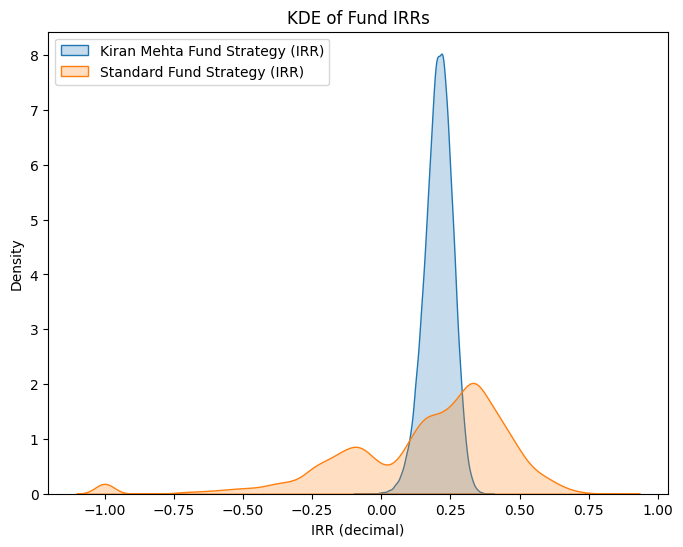

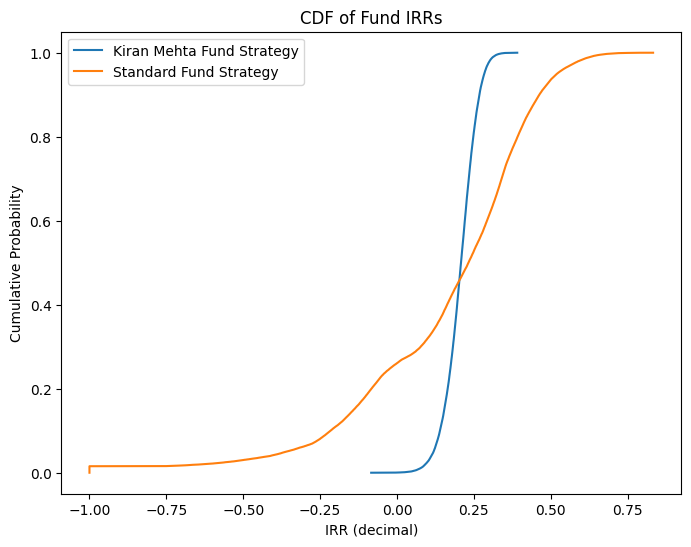

/var/folders/z_/z5wnb5q13n987g27_3c3yzwr0000gn/T/ipykernel_52539/644773820.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([kiran_irrs,std_irrs],


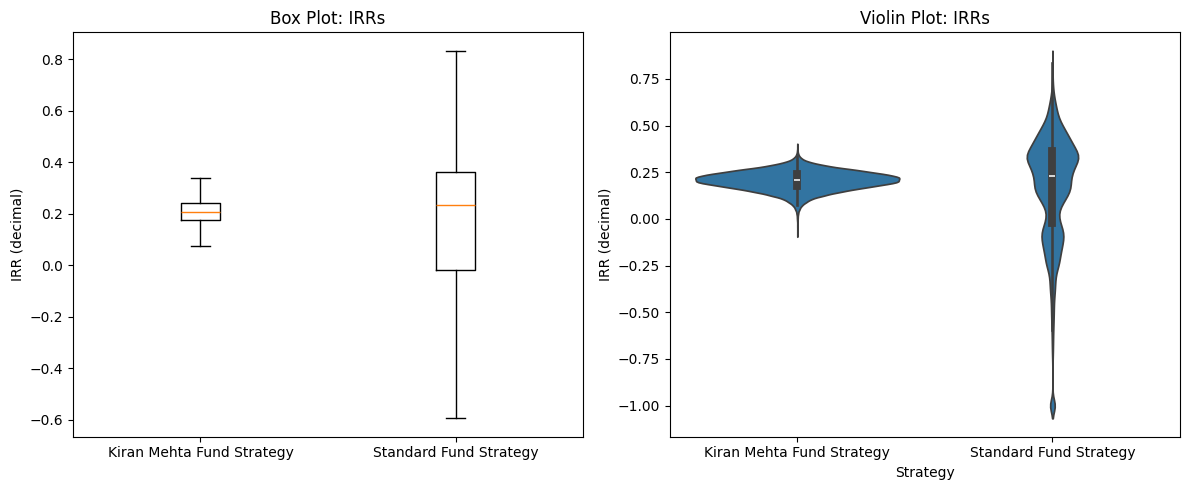

In [11]:
# 5) Plot IRRs
plot_kde_of_irrs(kiran_irrs, std_irrs)
plot_cdf_of_irrs(kiran_irrs, std_irrs)
plot_box_violin_of_irrs(kiran_irrs, std_irrs)

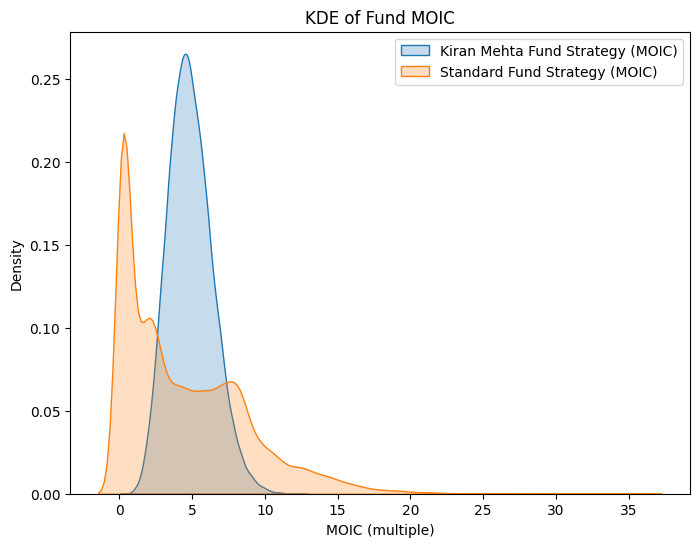

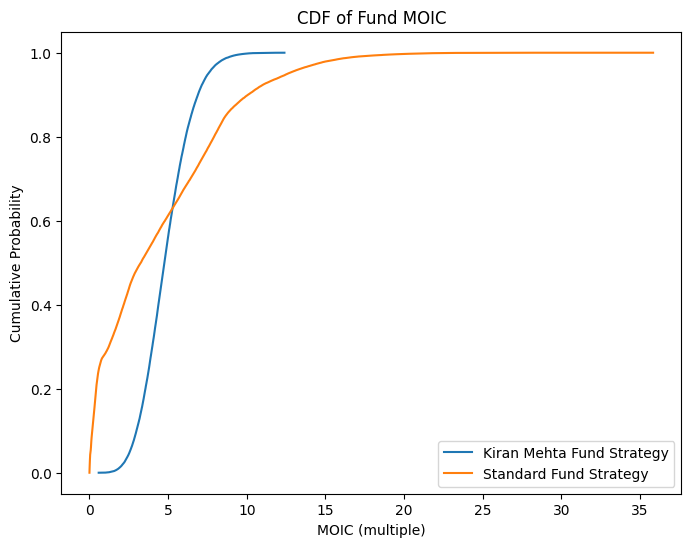

/var/folders/z_/z5wnb5q13n987g27_3c3yzwr0000gn/T/ipykernel_52539/644773820.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([kiran_moic,std_moic],


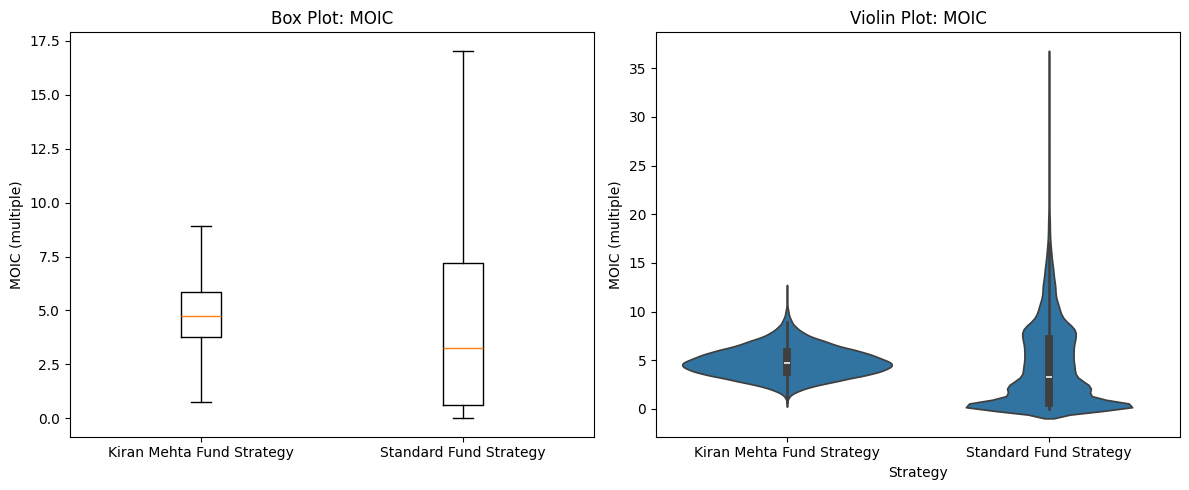

In [12]:
# 6) Plot MOIC
plot_kde_of_moic(kiran_moic, std_moic)
plot_cdf_of_moic(kiran_moic, std_moic)
plot_box_violin_of_moic(kiran_moic, std_moic)

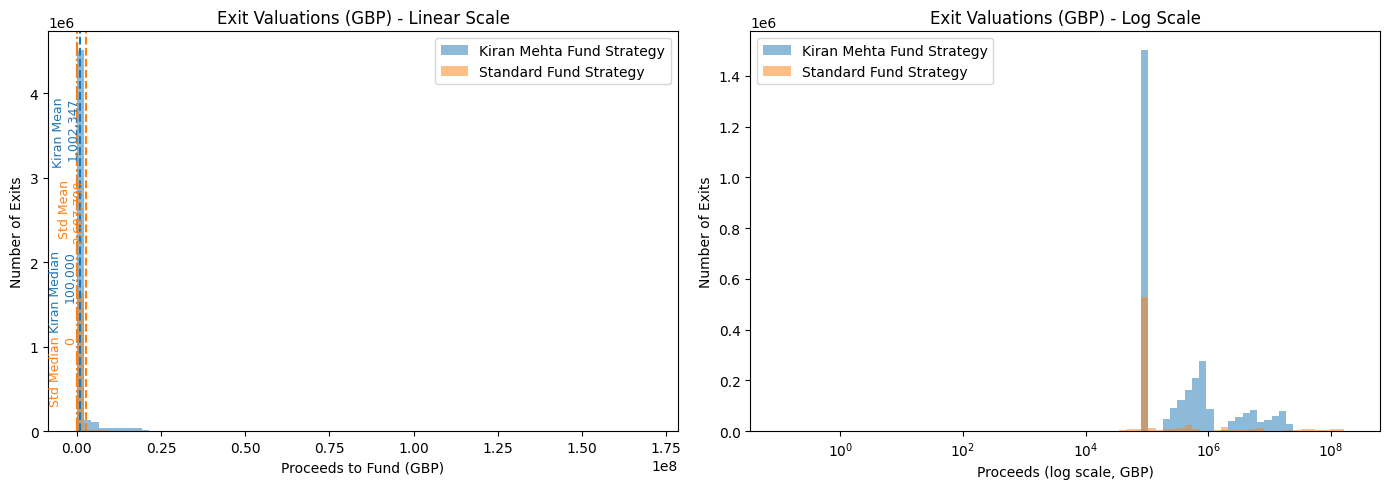

In [13]:
# 7) Plot exit valuations
plot_exit_valuations_histogram(kiran_exvals, std_exvals)